## Importing libraries

In [62]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from einops import rearrange
from torch import einsum


## Generating vocabulary and reading the dataset

In [63]:
lines = open('/Users/yashsurange/Documents/GitHub/Mulitmodal_llms/tinyshakespear.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [64]:
len(vocab)

65

In [65]:
# Approx 1M tokens which here are characters, original llama was trained on 1.4T tokens
len([i for i in lines])


1115393

## Using character level tokenizer for this implementation

In [66]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [20]:
encode('yash')

[63, 39, 57, 46]

In [23]:
decode([23,4,54])

'K&p'

******

### Note 1: Using config object to store parameters. Helps with readability. This will go into a separate file.

*****

In [67]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}


## Creating dataset

In [68]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115393])

## Creating batches


****

### Note 2: Will use same for train, validation and testing. Testing functions on the go is important

*****

In [69]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y


MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('e murderer shall', ' murderer shall '),
 ('lk of. Tell me, ', 'k of. Tell me, d'),
 ('A marvellous poo', ' marvellous poor'),
 (',\nAnd so I am: t', '\nAnd so I am: th'),
 ('ve.\nAnd leave yo', 'e.\nAnd leave you'),
 ('ch so took effec', 'h so took effect'),
 ('ow the beam of s', 'w the beam of si'),
 ('ad a volume of f', 'd a volume of fa')]

In [70]:
xs[0]

tensor([43,  1, 51, 59, 56, 42, 43, 56, 43, 56,  1, 57, 46, 39, 50, 50])

In [69]:
ys[0]

tensor([43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21,  1, 41, 56])

In [58]:
xs[0][:16]

tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21,  1, 41])

In [70]:
for i in range(MASTER_CONFIG['context_window']-1):
  context=xs[0][:i+1]
  target=xs[0][i+1]
  print(f"with context:{context} and target is: {target}")

with context:tensor([50]) and target is: 43
with context:tensor([50, 43]) and target is: 56
with context:tensor([50, 43, 56]) and target is: 1
with context:tensor([50, 43, 56,  1]) and target is: 44
with context:tensor([50, 43, 56,  1, 44]) and target is: 56
with context:tensor([50, 43, 56,  1, 44, 56]) and target is: 47
with context:tensor([50, 43, 56,  1, 44, 56, 47]) and target is: 43
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43]) and target is: 52
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52]) and target is: 42
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42]) and target is: 57
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57]) and target is: 6
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6]) and target is: 0
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0]) and target is: 21
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21]) and target is: 1
with context:tensor([50,

### These are the examples that are packed inside the input

****

### Note 3: To make the model work: 1. shapes of tensors should not cause problems hence no compilation erros 2. model loss should go down. It is useful to create a method to evaluate the model first.

****

## Creating evaluation method

In [71]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [74]:
# Initial loss i.e before any training
evaluate_loss(model)

{'train': 4.173854684829712, 'val': 4.173903846740723}

## Creating a simple model- we will build llama by swapping out parts of this model eventually

In [73]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("model params:", sum([m.numel() for m in self.parameters()]))

    
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        
        logits = F.softmax(a, dim=-1)
        

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits,loss=model(xs,ys)

model params: 33217


In [75]:
ys.shape

torch.Size([8, 16])

In [51]:
ys.view(-1).shape

torch.Size([128])

In [22]:
xs

tensor([[50, 53, 53, 49, 43, 42,  1, 58, 53, 61, 39, 56, 42,  1, 17, 52],
        [ 1, 57, 46, 39, 50, 50,  1, 52, 53, 58,  8,  0, 25, 43, 58, 46],
        [61,  1, 50, 47, 49, 43,  1, 63, 53, 59,  1, 53, 59, 56,  1, 41],
        [ 1, 59, 52, 44, 43, 47, 45, 52, 43, 42,  1, 44, 56, 47, 43, 52],
        [60, 39, 58, 43,  1, 44, 56, 47, 43, 52, 42, 57,  1, 59, 54, 53],
        [46, 43, 56, 43,  1, 57, 46, 39, 50, 50,  1, 57, 61, 43, 39, 56],
        [45, 10,  1, 63, 53, 59,  1, 61, 43, 56, 43,  1, 59, 57, 43, 42],
        [50, 63,  1, 45, 47, 60, 43, 52,  6,  1, 46, 43,  1, 51, 47, 45]])

In [23]:
ys

tensor([[53, 53, 49, 43, 42,  1, 58, 53, 61, 39, 56, 42,  1, 17, 52, 45],
        [57, 46, 39, 50, 50,  1, 52, 53, 58,  8,  0, 25, 43, 58, 46, 47],
        [ 1, 50, 47, 49, 43,  1, 63, 53, 59,  1, 53, 59, 56,  1, 41, 46],
        [59, 52, 44, 43, 47, 45, 52, 43, 42,  1, 44, 56, 47, 43, 52, 42],
        [39, 58, 43,  1, 44, 56, 47, 43, 52, 42, 57,  1, 59, 54, 53, 52],
        [43, 56, 43,  1, 57, 46, 39, 50, 50,  1, 57, 61, 43, 39, 56,  1],
        [10,  1, 63, 53, 59,  1, 61, 43, 56, 43,  1, 59, 57, 43, 42,  1],
        [63,  1, 45, 47, 60, 43, 52,  6,  1, 46, 43,  1, 51, 47, 45, 46]])

## Training now- To confirm that gradients are flowing back correctly, we can then swap out parts of this model with llama and train again. Its important to log the training runs.

model params: 33217
validation loss:  3.9463608503341674


<Axes: >

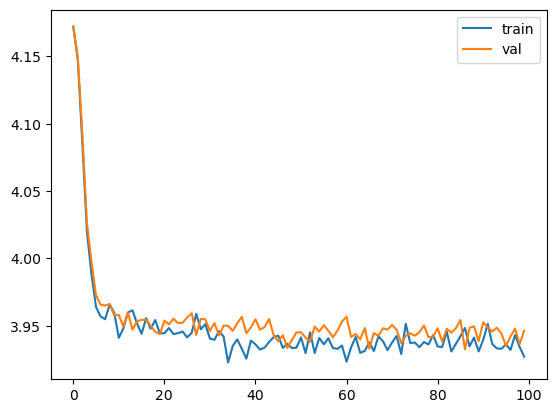

In [76]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

*********
### On intuitively observing the the results, we can say that model has not learned much. Comes down to analyzing the cross entropy loss before model training and after model training.
******

## Improvement 1: Removing the softmax layer. Inputs passed through cross entropy function should be unnormalized.

model params: 33217
validation loss:  2.5225677490234375


<Axes: >

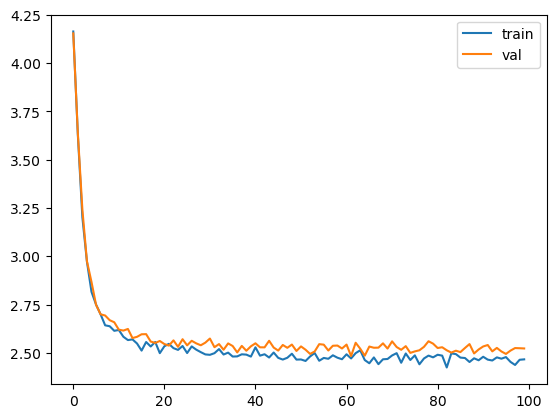

In [77]:
class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

## Adding generate method at the end of the training pipeline to visualize results

In [78]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        #print(logits.shape)
        
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
        
    return [decode(x) for x in idx.tolist()]

generate(model)

["\n\nGBerou?\n\nYo'sthis t ole,\nBY O",
 '\n\nHathe:\nTe Wif t to f t HAno u',
 '\nIOUTheeecoppagy conelve ck h t',
 '\nS:\nDhe ad\nAGLUSh:\n\nF be f, tor',
 '\nWhan w divein my etata-\n\n\n\nWh ']

### Note: We have a working end to end model, now we will bring this closer to llama

**********
### LLaMA adds 3 things to the transformer model

1. RMSNorm for pre-normalization
2. Rotary embeddings
3. SwiGLU activation function

We will add each one and iterate
**********

## RMS Norm

Instead of using batch normzalization as in the original transformer paper, Llama uses rmsnorm. In this, vectors are scaled using variances instead of centering it. Instead of applying it after attention layer, Llama uses it before attention layer

In [79]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


## Testing RMS norm- The RMSNorm has the property where the norm of the layer will be the square root of the number of elements in the layer, so we can check that for every layer

In [80]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)

assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

## Putting RMS Norm in our model

model params: 35265
validation loss:  2.5192952156066895


<Axes: >

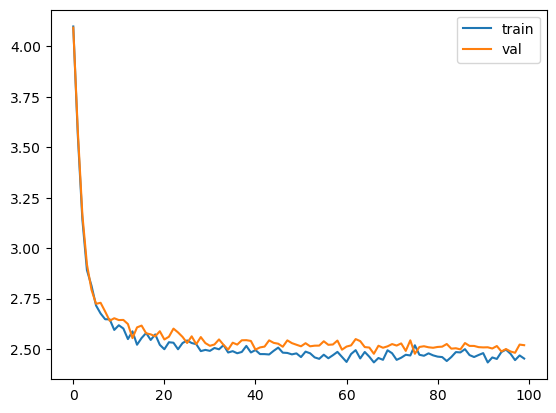

In [81]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [82]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

In [16]:
get_rotary_matrix(2,4)

tensor([[[ 1.0000, -0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.8623,  0.5064,  0.0000,  0.0000],
         [-0.5064,  0.8623,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.5403, -0.8415],
         [ 0.0000,  0.0000,  0.8415,  0.5403]]])

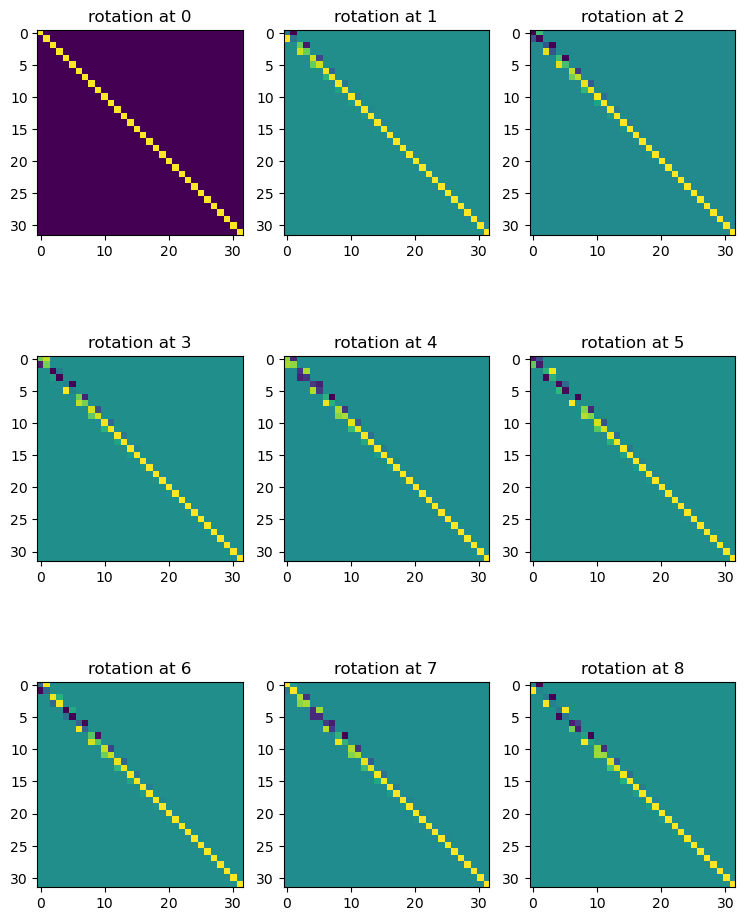

In [244]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])

fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

## ROPE check- check the maths of this

In [17]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

In [28]:

config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        # First calculating q,k,v
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)
        

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1
        )
        
        if return_attn_weights:
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [29]:
output.shape

torch.Size([10, 16, 512])

In [30]:
batch_inference=torch.randn((1, 1, config['d_model']))
output_inference, attn_weights_inference = layer(batch_inference, return_attn_weights=True)

In [31]:
output_inference.shape

torch.Size([1, 1, 512])

### Note:

I hadn't completely understood why indexing was necessary but the following is an explanation:


Tip here: know the difference between tensor dimensions at train time vs tensor dimensions at inference time.

Although at train time, you can expect your tensor dimensions to match your model parameters closely, eg batch.shape = (config['batch_size'], config['context_window'], config['d_model']), at inference time, you may have to deal with a single example, eg batch.shape = (1, 1, config['d_model']). For this reason, you need to make sure that when you're indexing in the forward pass, you're indexing using shapes derived from the input, not necessarily the model parameters.

**************
Let's make sure it does what we think it does. For this layer, we're going to want to test three things:

that it rotates embeddings the way we think it does
that the attention mask used for causal attention is working properly.

1.

In [20]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)
# print(q.shape)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)


for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_rotated = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_rotated = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_rotated)

2.

In [21]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttentionHead(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)


assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)


/var/folders/31/4ls8ds9x7vl8895bddgntg700000gn/T/ipykernel_1542/3895307665.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400154748/work/aten/src/ATen/native/TensorShape.cpp:3618.)
  assert q.T @ k == q @ k # transpose is redundant


*****

Let's setup a multi-headed attention layer for this singular attention head and see what happens when we train.

In [83]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x
    
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

model params: 559681
torch.Size([32, 16])
validation loss:  0.1581590786576271


<Axes: >

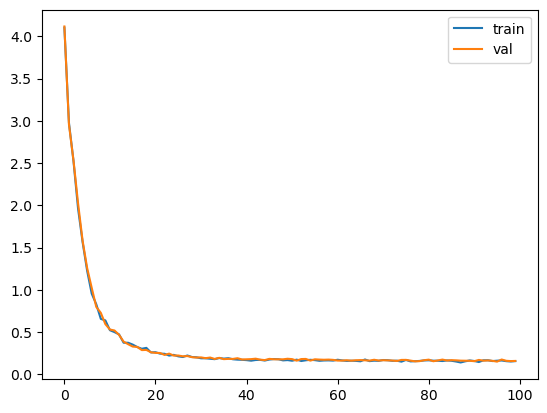

In [84]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
print(ys.shape)


logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

### Validation loss is low, doing a check on generation

In [86]:
generate(model, config=MASTER_CONFIG)

['\n\n\n\n\n\nEEENEQEEEE\nEEEEEEEEEEEEEE',
 '\n\n\n\n\n\n\nOOOOOOOOOOOOOOOOOOOOOOOO',
 '\n\n\n\n\n\n\n\n\n\n\n\nOOOOKOUCOLOOLEOO:O?',
 '\n\n\nOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOO\nOLLAOOLLEOO']